# 探索数据

- 用户特征
- 视频特征
- 交互数据

基本探索思路：
1. 加载数据，检查能否正常加载数据
2. 查看数据基本信息，如有哪些数据列(`df.columns`)，数据的形状(`df.shape`)，数据列的类型(`df.dtypes`或`df.info()`)，数据的基本统计信息(`df.describe()`)
3. 处理null值，填补null值或者丢弃null值所在的行
4. 删除重复数据
5. 检查各个列(属性)的分布，可以通过画图来分析

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter

pd.set_option('display.float_format', lambda x: f"{x:.3f}")

In [2]:
base_dir = "./2021_3_data"
test_data_dir  = os.path.join(base_dir, "testdata")
train_data_dir = os.path.join(base_dir, "traindata")

In [3]:
train_dirs = os.listdir(train_data_dir)
test_dirs  = os.listdir(test_data_dir)
print(train_dirs,'\n', test_dirs)

['history_behavior_data', 'user_features_data', 'video_features_data'] 
 ['test.csv']


## 用户特征

In [4]:
# 加载数据
user_data = pd.read_csv(os.path.join(train_data_dir, "user_features_data/user_features_data.csv"), delimiter="\t")

In [5]:
# 查看数据基本信息
print(user_data.columns.tolist())
print(user_data.shape)
user_data.head(5)

['user_id', 'age', 'gender', 'country', 'province', 'city', 'city_level', 'device_name']
(5910800, 8)


,user_id,age,gender,country,province,city,city_level,device_name
0,1757005,3,1,0,9,6,3,327
1,17938,0,0,0,4,22,3,327
2,4263520,1,0,0,19,1,5,327
3,1411600,3,0,0,5,138,1,327
4,3992242,2,0,0,0,142,0,327


In [6]:
user_data.info()
user_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910800 entries, 0 to 5910799
Data columns (total 8 columns):
 #   Column       Dtype
---  ------       -----
 0   user_id      int64
 1   age          int64
 2   gender       int64
 3   country      int64
 4   province     int64
 5   city         int64
 6   city_level   int64
 7   device_name  int64
dtypes: int64(8)
memory usage: 360.8 MB


,user_id,age,gender,country,province,city,city_level,device_name
count,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000
mean,2955399.500,1.886,0.285,0.001,9.176,86.034,2.057,72.104
std,1706301.130,1.564,0.478,0.030,7.878,81.779,1.662,79.275
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1477699.750,0.000,0.000,0.000,2.000,17.000,1.000,17.000
50%,2955399.500,2.000,0.000,0.000,7.000,59.000,2.000,46.000
75%,4433099.250,3.000,1.000,0.000,15.000,137.000,3.000,102.000
max,5910799.000,7.000,3.000,2.000,32.000,338.000,7.000,1825.000


In [8]:
col_null = user_data.apply(lambda x: sum(x.isnull()), axis=0)
# row_null = user_data.apply(lambda x: sum(x.isnull()), axis=1)

In [9]:
print(f"各列中存在null值的数量：\n{col_null}")
print(f"存在null值的行数：{sum(row_null != 0)}")

各列中存在null值的数量：
user_id        0
age            0
gender         0
country        0
province       0
city           0
city_level     0
device_name    0
dtype: int64
存在null值的行数：0


In [10]:
# 丢弃重复的行
user_data.drop_duplicates(inplace=True)

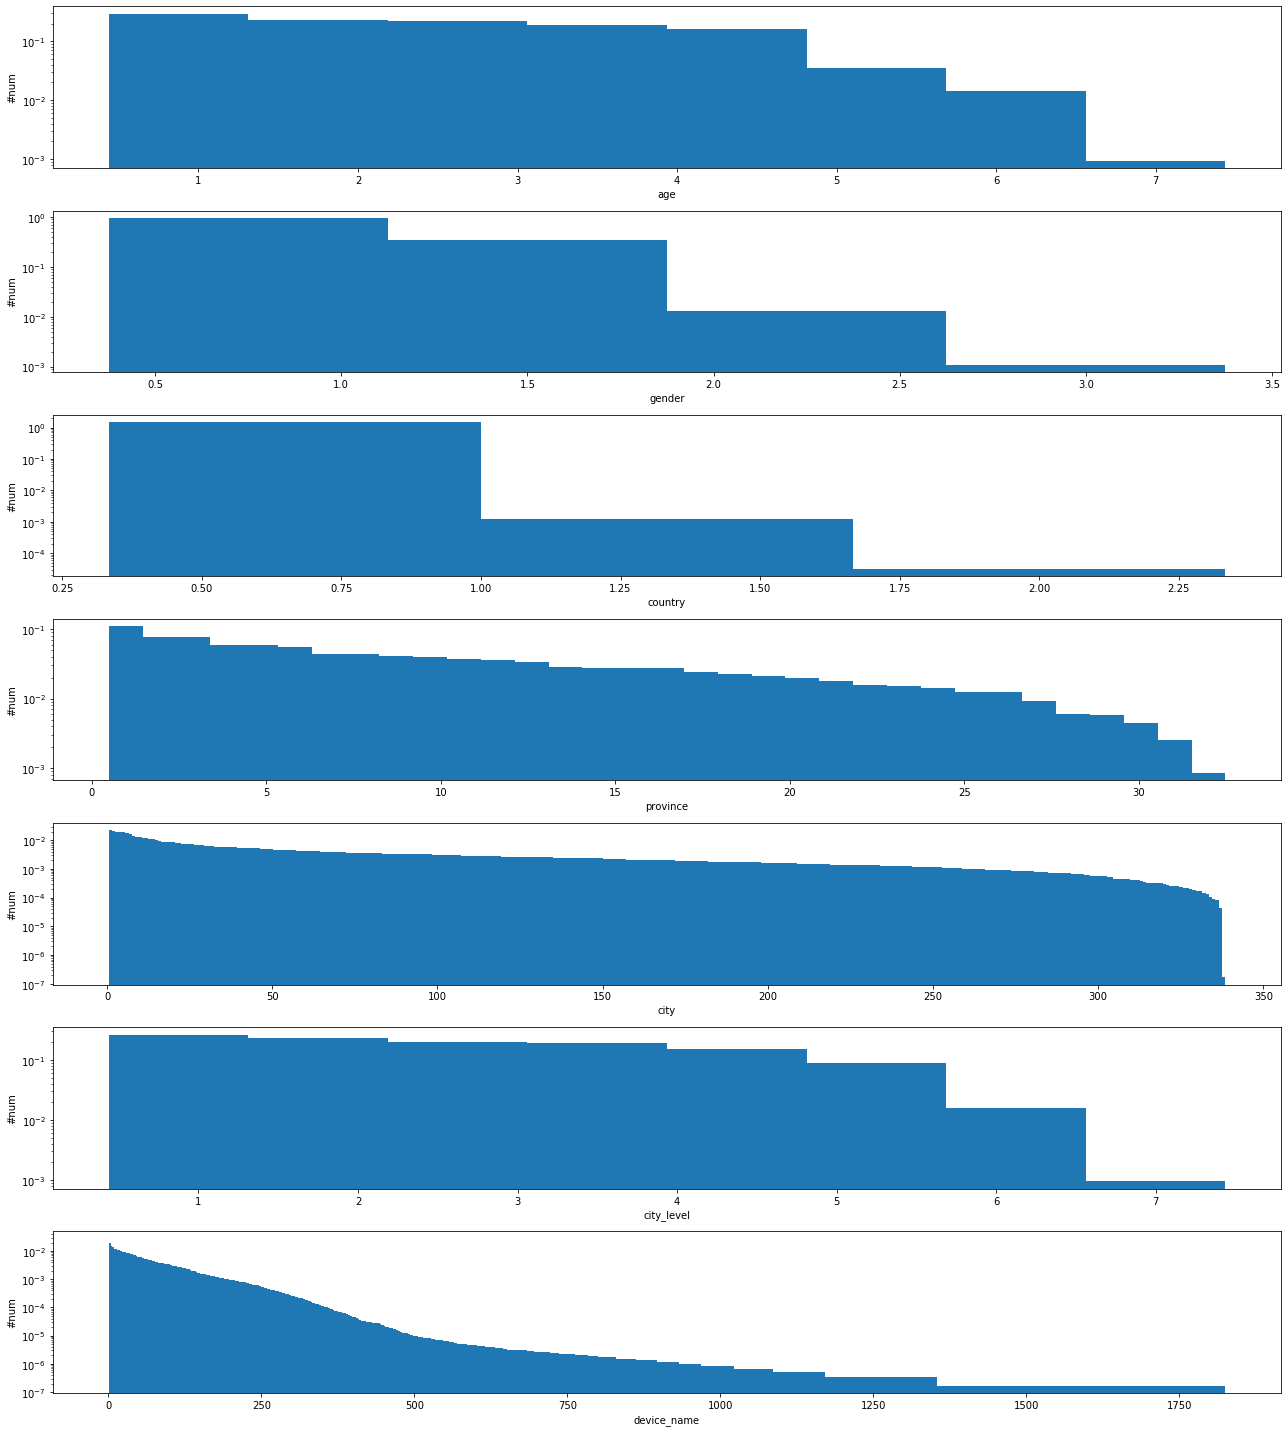

In [99]:
# 分析各个特征的分布
cols = user_data.columns.tolist()[1:]  # 去掉id列
fid, axes = plt.subplots(len(cols), 1, figsize=(18,20))

for idx, col in enumerate(cols):
    bins = len(user_data[col].unique())
    n, *_ = axes[idx].hist(user_data[col], bins=bins, align='right', density=True, log=True)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("#num")
#     print(f"{col} : {Counter(user_data[col])}, {[e/sum(n) for e in n]}")

plt.tight_layout()
plt.show()

## 视频特征

In [12]:
video_data = pd.read_csv(os.path.join(train_data_dir, "video_features_data/video_features_data.csv"), delimiter="\t")

In [13]:
print(video_data.shape)
print(video_data.columns.tolist())
video_data.head(5)

(49731, 10)
['video_id', 'video_name', 'video_tags', 'video_description', 'video_release_date', 'video_director_list', 'video_actor_list', 'video_score', 'video_second_class', 'video_duration']


,video_id,video_name,video_tags,video_description,video_release_date,video_director_list,video_actor_list,video_score,video_second_class,video_duration
0,3460,脱皮爸爸,"院线电影,家庭关系,命运","中年失意的儿子田力行（古天乐饰）在生活上遇到了重重危机：母亲病逝,工作不顺,妻子要求离婚。正...",2017-04-27,司徒慧焯,"吴镇宇,古天乐,春夏,蔡洁",7.400,"剧情,喜剧,奇幻",5913
1,14553,喜气洋洋小金莲,"古装喜剧,剧情片,喜剧片,内地电影,欢乐喜剧,爱情纠纷",故事始于西门庆为西门药业的“伟哥”产品寻找代言人，西门庆初见潘金莲，一时惊为天人，为成功抱得...,2015-12-30,"杨珊珊,李亚玲","陈南飞,程隆妮,王闯,贾海涛,闫薇儿",5.600,喜剧,6217
2,1214,风流家族,"男女关系,家庭关系,命运,院线电影",香世仁（钟镇涛 饰）是家财万贯的香港富豪，在满足了一切物质上的要求后，他将生活的重心放在了儿...,2002-03-07,"邱礼涛,杨漪珊","张家辉,卢巧音,钟镇涛,叶童,李蕙敏,张坚庭,袁洁莹,黄佩霞,齐芷瑶,刘以达,叶伟信,邹凯光...",6.800,"都市,喜剧,爱情,家庭",5963
3,30639,大提琴的故事,"短片,动画片",低音大提琴演奏家史密斯科夫正要去参加某贵族的沙龙，途中他被河边的美丽景色所吸引，驻足观看。兴...,1949-01-01,"伊里·特恩卡,契诃夫",NaN,nan,"动画,爱情",17371
4,38522,歌舞大王齐格飞,"喜剧片,人物传记,浪漫爱情",罗伯特．Z．伦纳德导演的这部影片以百老汇最大的歌舞团——齐格菲歌舞团的创办人佛罗伦斯．齐格菲...,1936-04-08,"罗伯特·Z·伦纳德,William Anthony McGuire","威廉·鲍威尔,玛娜·洛伊,路易丝·赖纳,弗兰克·摩根,范妮·布莱斯,弗吉尼亚·布鲁斯,雷吉纳...",7.700,"剧情,歌舞,喜剧",10608


In [18]:
video_data.info()
video_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49731 entries, 0 to 49730
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_id             49731 non-null  int64  
 1   video_name           49722 non-null  object 
 2   video_tags           41831 non-null  object 
 3   video_description    49536 non-null  object 
 4   video_release_date   49061 non-null  object 
 5   video_director_list  38728 non-null  object 
 6   video_actor_list     39543 non-null  object 
 7   video_score          46417 non-null  float64
 8   video_second_class   43821 non-null  object 
 9   video_duration       49731 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 3.8+ MB


,video_id,video_score,video_duration
count,49731.000,46417.000,49731.000
mean,25170.854,7.361,3675.074
std,14540.777,0.819,2862.818
min,0.000,5.000,0.000
25%,12579.500,7.000,148.000
50%,25161.000,7.400,5029.000
75%,37766.500,7.900,5817.000
max,50354.000,9.800,23536.000


# 交互数据

In [15]:
action_dirs = os.listdir(os.path.join(train_data_dir, "history_behavior_data"))
action_files = {e: os.listdir(os.path.join(train_data_dir, f"history_behavior_data/{e}"))[0] for e in action_dirs}
print(action_files)

{'20210419': 'part-00000-236b99d5-456a-42b2-bd8d-3cbd61d21cc6-c000.csv', '20210420': 'part-00000-aad75aa4-b60b-4f5b-8def-c4d60f391fae-c000.csv', '20210421': 'part-00000-c15f29da-6b1e-48c0-b7d0-2cd560998c3f-c000.csv', '20210422': 'part-00000-3d97d0f8-2572-45e6-bb60-f367c97e7870-c000.csv', '20210423': 'part-00000-9809d73a-a55f-4ac2-a59b-9b83cbc5028e-c000.csv', '20210424': 'part-00000-225e55dc-4504-4c14-b289-322312355b2b-c000.csv', '20210425': 'part-00000-9d23862b-6bbf-48c6-a598-572df1359737-c000.csv', '20210426': 'part-00000-0d315342-3ba7-4727-b4a2-123a1a004786-c000.csv', '20210427': 'part-00000-9132ab46-51c3-4cc3-97de-e7ad5312b852-c000.csv', '20210428': 'part-00000-fc8c8ca1-e655-4a45-b179-c8d9e2dd804c-c000.csv', '20210429': 'part-00000-c5dbd994-54d7-4734-adea-0f22d75b23d3-c000.csv', '20210430': 'part-00000-2da4c3a0-2fcc-422d-8b7c-48940da315ad-c000.csv', '20210501': 'part-00000-56b6f0ff-57b8-41ac-96ec-c20e3306297e-c000.csv', '20210502': 'part-00000-d412c602-2f4a-4649-a81f-e56435dd49fd-c0

In [128]:
i = action_dirs[1]
action_data = pd.read_csv(os.path.join(train_data_dir, f"history_behavior_data/{i}/{action_files[i]}"), delimiter="\t")

d:\codeprograms\python37\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [138]:
print(action_data.shape)
print(action_data.columns.tolist())
action_data.head(5)

(5511348, 7)
['user_id', 'video_id', 'is_watch', 'is_share', 'is_collect', 'is_comment', 'watch_label']


,user_id,video_id,is_watch,is_share,is_collect,is_comment,watch_label
0,2543081,5035,0,0,0,0,0
1,2543081,9527,0,0,0,0,0
2,2543081,3717,0,0,0,0,0
3,2543081,37417,0,0,0,0,0
4,2543081,28368,0,0,0,0,0


In [130]:
action_data.info()
# action_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5511348 entries, 0 to 5511347
Data columns (total 9 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           int64 
 1   video_id          int64 
 2   is_watch          int64 
 3   is_share          int64 
 4   is_collect        int64 
 5   is_comment        int64 
 6   watch_start_time  object
 7   watch_label       int64 
 8   pt_d              int64 
dtypes: int64(8), object(1)
memory usage: 378.4+ MB


In [131]:
# 按照 (user_id, video_id)进行分组。绝大部分用户基本只看了一个视频
d = action_data.duplicated(['user_id', 'video_id'])

In [132]:
d = d[d]
print(f"重复的(user_id, video_id)数量 : {d.shape[0]} ({d.shape[0]/action_data.shape[0]})")

重复的(user_id, video_id)数量 : 25 (4.536095343643697e-06)


In [133]:
col_null = action_data.apply(lambda x: sum(x.isnull()), axis=0)

In [134]:
col_null / action_data.shape[0] # 可见，watch_start_time大部分都为NaN

user_id            0.000
video_id           0.000
is_watch           0.000
is_share           0.000
is_collect         0.000
is_comment         0.000
watch_start_time   0.907
watch_label        0.000
pt_d               0.000
dtype: float64

In [135]:
# 删除列
action_data.drop('watch_start_time', inplace=True, axis=1)
action_data.drop('pt_d', inplace=True, axis=1)

is_watch : Counter({0: 5000945, 1: 510403}), [0.907, 0.093]
is_share : Counter({0: 5510400, 1: 948}), [1.0, 0.0]
is_collect : Counter({0: 5505237, 1: 6111}), [0.999, 0.001]
is_comment : Counter({0: 5510385, 1: 963}), [1.0, 0.0]
watch_label : Counter({0: 5363875, 1: 36171, 9: 28097, 2: 20349, 3: 14991, 4: 11810, 5: 9820, 8: 9375, 6: 8793, 7: 8067}), [0.973, 0.007, 0.004, 0.003, 0.002, 0.002, 0.002, 0.001, 0.002, 0.005]


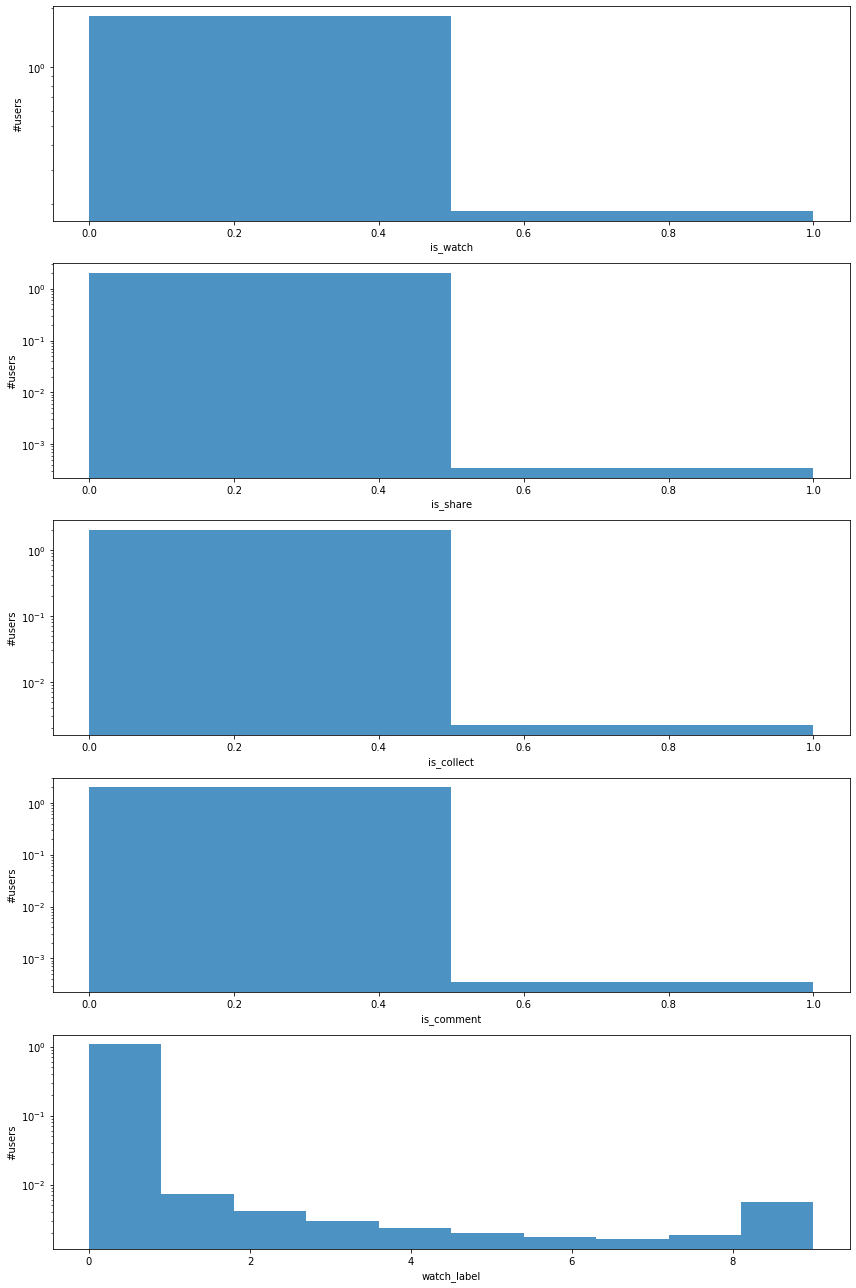

In [136]:
# 分析各个特征的分布
cols = action_data.columns.tolist()[2:]  # 去掉id列
# cols.remove('watch_start_time')
# cols.remove('pt_d')
fid, axes = plt.subplots(len(cols), 1, figsize=(12,18))



for idx, col in enumerate(cols):
    bins = len(action_data[col].unique())
    n, *_ = axes[idx].hist(action_data[col], bins=bins, align='mid', density=True, alpha=0.8, log=True)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("#users")
    print(f"{col} : {Counter(action_data[col])}, {[round(e/sum(n), 3) for e in n]}")

plt.tight_layout()
plt.show()

# 测试数据

In [20]:
test_data = pd.read_csv(os.path.join(test_data_dir, "test.csv"))

In [21]:
print(test_data.shape)
print(test_data.columns.tolist())
test_data.head(5)

(2822180, 2)
['user_id', 'video_id']


,user_id,video_id
0,1688013,32645
1,4502598,41270
2,5585629,16345
3,1635520,28149
4,4160191,40554


In [23]:
print(f"unique users  : {len(test_data['user_id'].unique())}")
print(f"unique videos : {len(test_data['video_id'].unique())}")

unique users  : 492174
unique videos : 23686


In [137]:
# 检查测试数据中的(user_id, video_id)是否出现在历史行为数据中
pd.merge(action_data, test_data, on=['user_id', 'video_id'], how='inner')

,user_id,video_id,is_watch,is_share,is_collect,is_comment,watch_label
0,4206081,12968,0,0,0,0,0
1,2828977,1759,0,0,0,0,0
2,3861990,23410,0,0,0,0,0
3,1093230,29453,0,0,0,0,0
4,1093230,28413,0,0,0,0,0
...,...,...,...,...,...,...,...
26767,3944251,50299,1,0,1,1,0
26768,5614611,47507,1,0,0,0,0
26769,5614611,15888,1,0,0,0,7
26770,3218613,5601,1,0,0,0,7


In [34]:
action_data[(action_data['user_id'] == 1869184) & (action_data['video_id'] == 12968)]

,user_id,video_id,is_watch,is_share,is_collect,is_comment,watch_start_time,watch_label,pt_d
5582603,1869184,12968,1,0,0,0,2021-04-19,0,20210419


In [35]:
test_data[(test_data['user_id'] == 1869184) & (test_data['video_id'] == 12968)]

,user_id,video_id
951388,1869184,12968
